In [2]:
import sys 
sys.path.append("../")
from data import generate_mnist

trainset, testset, class_labels = generate_mnist()
len(trainset), len(testset), trainset[0][0].size(), trainset[0][1]

(60000, 10000, torch.Size([1, 28, 28]), 5)

In [3]:
import torch 
import torch.nn as nn 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.classifier = nn.Linear(3136, 10)
        self.flatten = nn.Flatten()
        self.feature = nn.Sequential(
           nn.Conv2d(1,16, 3,1,1),
           nn.ReLU(),
           nn.MaxPool2d(2),
           nn.Conv2d(16,32, 3,1,1),
           nn.ReLU(),
           nn.MaxPool2d(2),
           nn.Conv2d(32,64, 3,1,1)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x) 
        return x 

complex_model = CNN()
complex_model.cuda()

CNN(
  (classifier): Linear(in_features=3136, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (feature): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(complex_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 12 

for epoch in range(epochs):
    running_loss = 0
    for i, (x,y) in enumerate(train_loader):
        prediction = complex_model(x.cuda())
        loss = criterion(prediction, y.cuda())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        
    print("🚀 Epoch:{1} | Loss(recon):{0:6.4f} ".format(running_loss/(i+1), epoch))
        


🚀 Epoch:0 | Loss(recon):2.2977 | ⭐️ Progress
🚀 Epoch:1 | Loss(recon):0.1087 | ⭐️ Progress
🚀 Epoch:2 | Loss(recon):0.0908 | ⭐️ Progress
🚀 Epoch:3 | Loss(recon):0.1500 | ⭐️ Progress
🚀 Epoch:4 | Loss(recon):0.0119 | ⭐️ Progress
🚀 Epoch:5 | Loss(recon):0.1173 | ⭐️ Progress
🚀 Epoch:6 | Loss(recon):0.0101 | ⭐️ Progress
🚀 Epoch:7 | Loss(recon):0.1149 | ⭐️ Progress
🚀 Epoch:8 | Loss(recon):0.0313 | ⭐️ Progress
🚀 Epoch:9 | Loss(recon):0.0583 | ⭐️ Progress
🚀 Epoch:10 | Loss(recon):0.0488 | ⭐️ Progress
🚀 Epoch:11 | Loss(recon):0.0017 | ⭐️ Progress


## Train LIME 

In [63]:
# === LIME =====

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.classifier = nn.Linear(16, 10)
        self.flatten = nn.Flatten()
        self.feature = nn.Sequential(
           nn.Conv2d(1,16, 3,3,1),
           nn.ReLU(),
           nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x) 
        return x 

simple_model = SmallCNN()
simple_model.cuda()

SmallCNN(
  (classifier): Linear(in_features=16, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (feature): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU()
    (2): AdaptiveAvgPool2d(output_size=1)
  )
)

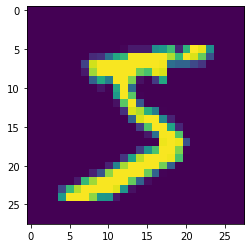

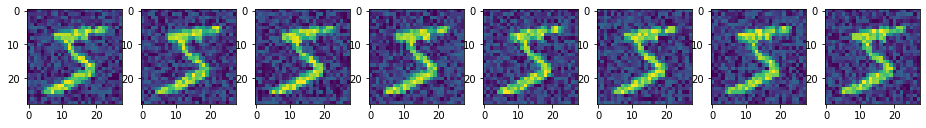

In [64]:
local_x = trainset[0][0]
local_y = None # predicted by the complex model


def generate_epsilon_batch(x, batch_size=32, std=0.5):
    batch = [] 
    for i in range(batch_size):
        epsilon = torch.rand_like(x) * std
        batch.append(x+epsilon)
    return torch.stack(batch)


import matplotlib.pyplot as plt 
std = 0.5
plt.figure(figsize=(4,4))
plt.imshow(local_x.permute(1,2,0))
fig, axes = plt.subplots(1,8, figsize=(16,4))
batch = generate_epsilon_batch(local_x, 32, std=std)
for i in range(8):
    axes[i].imshow(batch[i].permute(1,2,0))

In [72]:
from torch.utils.data import DataLoader

optimizer = torch.optim.Adam(simple_model.parameters(), lr=1e-4, weight_decay=0.01)  # Weight decay to penalty model complexity 
criterion = nn.CrossEntropyLoss()
epochs = 2000

complex_model.eval()
running_loss = 0
for epoch in range(epochs):
    x = generate_epsilon_batch(local_x)
    local_y = complex_model(x.cuda()).argmax(axis=-1)
    prediction = simple_model(x.cuda())
    loss = criterion(prediction, local_y.cuda())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item() 
    if epoch % 100 ==0:
        print("🚀 Epoch:{1} | Loss(recon):{0:6.4f} ".format(running_loss/(epoch+1), epoch))
        

🚀 Epoch:0 | Loss(recon):0.5161 
🚀 Epoch:100 | Loss(recon):0.4490 
🚀 Epoch:200 | Loss(recon):0.3939 
🚀 Epoch:300 | Loss(recon):0.3479 
🚀 Epoch:400 | Loss(recon):0.3098 
🚀 Epoch:500 | Loss(recon):0.2781 
🚀 Epoch:600 | Loss(recon):0.2517 
🚀 Epoch:700 | Loss(recon):0.2294 
🚀 Epoch:800 | Loss(recon):0.2103 
🚀 Epoch:900 | Loss(recon):0.1939 
🚀 Epoch:1000 | Loss(recon):0.1798 
🚀 Epoch:1100 | Loss(recon):0.1675 
🚀 Epoch:1200 | Loss(recon):0.1567 
🚀 Epoch:1300 | Loss(recon):0.1472 
🚀 Epoch:1400 | Loss(recon):0.1388 
🚀 Epoch:1500 | Loss(recon):0.1314 
🚀 Epoch:1600 | Loss(recon):0.1246 
🚀 Epoch:1700 | Loss(recon):0.1186 
🚀 Epoch:1800 | Loss(recon):0.1131 
🚀 Epoch:1900 | Loss(recon):0.1082 


### Convolution Weights

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): AdaptiveAvgPool2d(output_size=1)
)


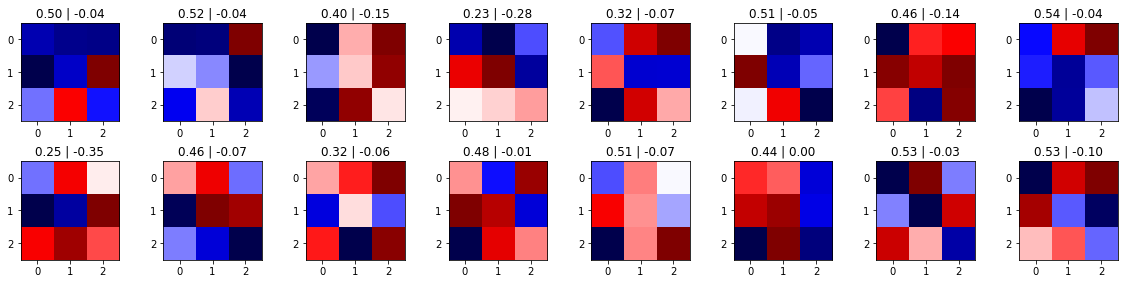

In [66]:
print(simple_model.feature)
fig, axes = plt.subplots(2,8, figsize=(16, 4))
for i in range(2):
    for j in range(8):
        filter = simple_model.feature[0].weight[i*8+j,0,:,:]
        axes[i][j].imshow(filter.cpu().detach().numpy(), cmap="seismic")
        axes[i][j].set_title(f"{filter.max().item():.2f} | {filter.min().item():.2f}")
plt.tight_layout()

### Classifier weight

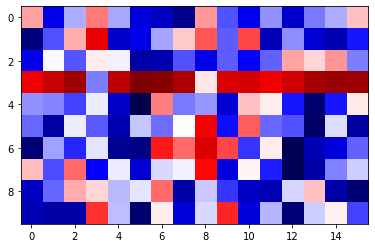

In [70]:
simple_model.classifier.weight.size()
plt.figure(figsize=(16, 4))
plt.imshow(simple_model.classifier.weight.cpu().detach().numpy(), cmap="seismic")
